In [212]:
from tqdm import tqdm
import random
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
from omegaconf import OmegaConf
from copy import deepcopy
from torchdyn.core import NeuralODE
from cfgen.models.fm.ode import torch_wrapper
from cfgen.data.scrnaseq_loader import RNAseqLoader
from cfgen.models.base.encoder_model import EncoderModel
from cfgen.models.fm.fm import FM
from scvi.distributions import NegativeBinomial
from tqdm import tqdm

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(4, 4)) 

## Initialize dataset and encoder

In [213]:
dataset_conf = OmegaConf.load("../../configs/configs_sccfm/dataset/neurips_multiattribute.yaml")
encoder_conf = OmegaConf.load("../../configs/configs_encoder/encoder/default.yaml")

Initialize dataset

In [214]:
dataset = RNAseqLoader(dataset_conf.dataset_path,
                        layer_key=dataset_conf.layer_key,
                        covariate_keys=dataset_conf.covariate_keys,
                        subsample_frac=dataset_conf.subsample_frac, 
                        normalization_type=dataset_conf.normalization_type,
                        is_binarized=dataset_conf.is_binarized)

dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=1024,
                                        shuffle=False,
                                        drop_last=False)

in_dim = dataset.X["rna"].shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Initialize Autoencoder

In [215]:
gene_dim = {mod: dataset.X[mod].shape[1] for mod in dataset.X}

encoder_model = EncoderModel(in_dim=gene_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_conf.theta_covariate, 
                              **encoder_conf)

In [216]:
state_dict_path = "../../project_folder/experiments/autoencoder_ckpt/train_autoencoder_neurips_final/checkpoints/last.ckpt"
encoder_model.load_state_dict(torch.load(state_dict_path, weights_only=False)["state_dict"])

<All keys matched successfully>

## Initialize Flow Matching model

In [217]:
generative_model_config = OmegaConf.load("../../configs/configs_sccfm/generative_model/default.yaml")

In [218]:
ckpt = torch.load("../../project_folder/experiments/cfgen_neurips_final_multiattribute/28ea27d8-d3ae-4ca5-8253-2545c5780e62/checkpoints/last.ckpt", weights_only=False)

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [219]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-1.1919e+00,  9.6713e-01, -4.0400e-01,  ...,  1.4990e-01,
         -2.3992e-01, -1.6981e+00],
        [-9.5007e-01, -4.0087e-04, -1.3513e-01,  ..., -1.0168e-01,
          6.3976e-01,  4.8783e-02],
        [-1.2764e+00,  8.9267e-01,  1.2118e+00,  ..., -1.1157e+00,
         -3.4798e-01, -6.2901e-01],
        ...,
        [ 1.4575e+00, -2.3533e+00, -4.4071e-01,  ...,  3.5451e-01,
         -2.3695e-01,  3.7931e-01],
        [ 1.9369e-01,  1.2067e+00,  2.0353e+00,  ..., -2.3205e-01,
          8.8236e-01, -2.2540e-01],
        [ 1.0133e+00,  1.2378e+00,  3.6552e-01,  ...,  4.9222e-01,
          2.6295e-01,  2.8432e+00]], device='cuda:0', requires_grad=True)


In [220]:
dataset_conf["guidance_weights"]

{'cell_type': 1, 'Site': 1}

In [221]:
generative_model = FM(encoder_model=encoder_model,
                        denoising_model=denoising_model,
                        feature_embeddings=feature_embeddings,
                        plotting_folder=None,
                        in_dim={"rna": 50},
                        size_factor_statistics=size_factor_statistics,
                        covariate_list=["cell_type"],
                        theta_covariate="cell_type",
                        size_factor_covariate=dataset_conf["size_factor_covariate"],
                        is_binarized=False,
                        modality_list=["rna"],
                        guidance_weights={'cell_type': 1, 'Site': 1},
                        **generative_model_config  # model_kwargs should contain the rest of the arguments
                        )

# generative_model.denoising_model.embed_size_factor = True
generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (encoder): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=14087, out_features=512, bias=True)
            (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
            (0): Linear(in_features=512, out_features=256, bias=True)
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (2): Linear(in_features=256, out_features=50, bias=True)
        )
      )
    )
    (decoder): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=50, out_features=256, bias=True)
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          

## Load real dataset 

In [222]:
adata_original = sc.read_h5ad(dataset_conf["dataset_path"].replace("train", "test"))
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.toarray().sum(1)

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [223]:
adata_original

AnnData object with n_obs × n_vars = 18053 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'size_factor'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'dataset_id', 'genome', 'log1p', 'neighbors', 'organism', 'pca', 'umap'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

## Generate and save cells

In [224]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
unique_classes = dict(zip(unique_classes[0], unique_classes[1]))
unique_classes

{'B1 B IGKC+': np.int64(167),
 'B1 B IGKC-': np.int64(120),
 'CD14+ Mono': np.int64(4360),
 'CD16+ Mono': np.int64(552),
 'CD4+ T CD314+ CD45RA+': np.int64(21),
 'CD4+ T activated': np.int64(1409),
 'CD4+ T activated integrinB7+': np.int64(200),
 'CD4+ T naive': np.int64(1185),
 'CD8+ T CD49f+': np.int64(154),
 'CD8+ T CD57+ CD45RA+': np.int64(276),
 'CD8+ T CD57+ CD45RO+': np.int64(294),
 'CD8+ T CD69+ CD45RA+': np.int64(139),
 'CD8+ T CD69+ CD45RO+': np.int64(181),
 'CD8+ T TIGIT+ CD45RA+': np.int64(207),
 'CD8+ T TIGIT+ CD45RO+': np.int64(226),
 'CD8+ T naive': np.int64(620),
 'CD8+ T naive CD127+ CD26- CD101-': np.int64(5),
 'Erythroblast': np.int64(805),
 'G/M prog': np.int64(398),
 'HSC': np.int64(337),
 'ILC': np.int64(47),
 'ILC1': np.int64(112),
 'Lymph prog': np.int64(361),
 'MAIT': np.int64(148),
 'MK/E prog': np.int64(123),
 'NK': np.int64(1103),
 'NK CD158e1+': np.int64(430),
 'Naive CD20+ B IGKC+': np.int64(786),
 'Naive CD20+ B IGKC-': np.int64(408),
 'Normoblast': np.in

## Collect the data

In [225]:
adata_original = sc.read_h5ad(dataset_conf["dataset_path"])
 
colorblind_palette = sns.color_palette("colorblind", 4).as_hex()
adata_original.uns['Site_colors'] = colorblind_palette

adata_original.obs["size_factor"]=adata_original.X.toarray().sum(1)
adata_original.X = adata_original.layers["X_counts"].toarray().copy()
X = torch.tensor(adata_original.layers["X_counts"].todense())

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


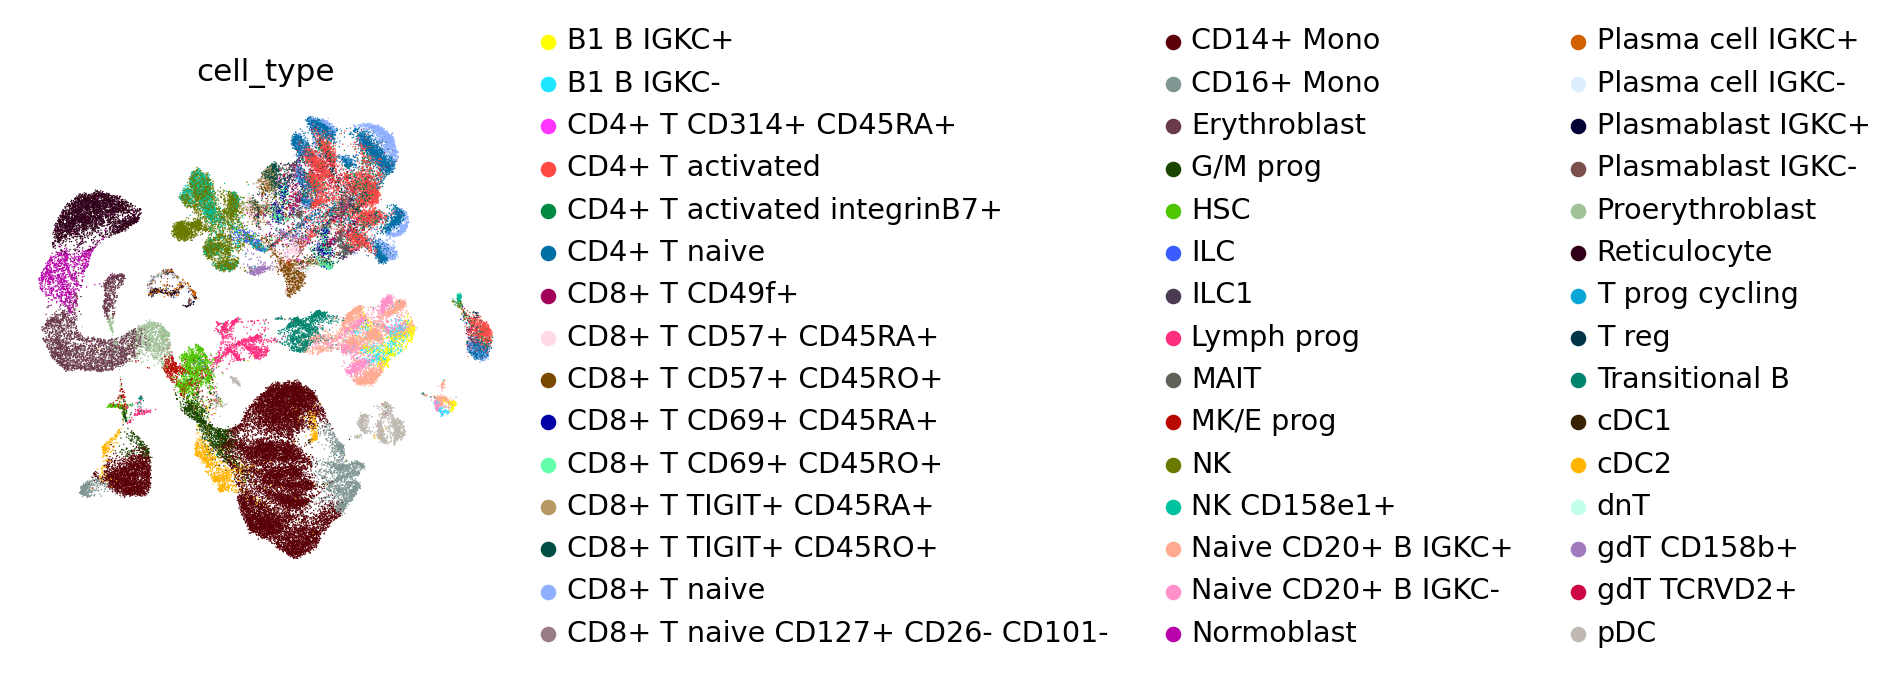

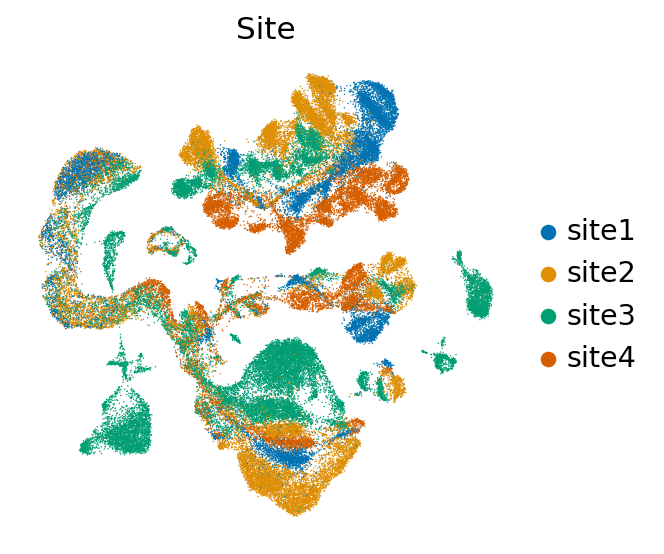

In [226]:
sc.pl.umap(adata_original, color=["cell_type"])
sc.pl.umap(adata_original, color=["Site"])

In [227]:
# Inverted --> Corrected 
X_inverted = []
X_corrected = [] 
X_corrected_decoded = []
encoded_lab = {"cell_type": [],
              "Site": []}

# Times to apply correction
t = torch.linspace(0.0, 1.0, 100, device=generative_model.device)
reverse_t = torch.linspace(1.0, 0.0, 100, device=generative_model.device)

for batch in tqdm(dataloader):
    with torch.no_grad():
        # Encode latent space 
        z = encoder_model.encode(batch)["rna"]
        
        for cov in batch["y"]:
            encoded_lab[cov] += batch["y"][cov].tolist()

        # Get size factor
        log_size_factor = torch.log(batch["X"]["rna"].sum(1))

        # Get condition embeddings
        y = {}
        for c in batch["y"]:
            y[c] = generative_model.feature_embeddings[c](batch["y"][c].cuda())

        # Go back to noise
        denoising_model_ode = torch_wrapper(generative_model.denoising_model, 
                                            log_size_factor, 
                                            y,
                                            guidance_weights=generative_model.guidance_weights,
                                            conditioning_covariates=["cell_type", "Site"], 
                                            unconditional=False)    
        
        node = NeuralODE(denoising_model_ode,
                                solver="dopri5", 
                                sensitivity="adjoint", 
                                atol=1e-5, 
                                rtol=1e-5)        

        z0 = node.trajectory(z, t_span=reverse_t)[-1]
        X_inverted.append(z0)

        y["Site"] = generative_model.feature_embeddings["Site"]((torch.ones(z0.shape[0]) * 3).long())
        
        # Decode noise with single batch
        denoising_model_ode = torch_wrapper(generative_model.denoising_model, 
                                            log_size_factor, 
                                            y,
                                            guidance_weights=generative_model.guidance_weights,
                                            conditioning_covariates=["cell_type", "Site"], 
                                            unconditional=False)    

        z1 = node.trajectory(z0, t_span=t)[-1]
        X_corrected.append(z1)

        # Now decode
        mu_hat = generative_model._decode({"rna": z1}, {"rna": torch.exp(log_size_factor).cuda().unsqueeze(1)})
        distr = NegativeBinomial(mu=mu_hat["rna"], theta=torch.exp(encoder_model.theta))
        X_corrected_decoded.append(distr.sample())

100%|██████████| 71/71 [03:39<00:00,  3.09s/it]


In [228]:
X_inverted = torch.cat(X_inverted, dim=0)
X_corrected = torch.cat(X_corrected, dim=0)
X_corrected_decoded = torch.cat(X_corrected_decoded, dim=0)

In [229]:
obs = pd.DataFrame(encoded_lab)

In [230]:
cov2id = {"Site": {val:key for key,val in dataset.id2cov["Site"].items()}, 
            "cell_type": {val:key for key,val in dataset.id2cov["cell_type"].items()}}

obs["cell_type"] = [cov2id["cell_type"][lab] for lab in obs["cell_type"]]
obs["Site"] = [cov2id["Site"][lab] for lab in obs["Site"]]

Visualize inverted

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


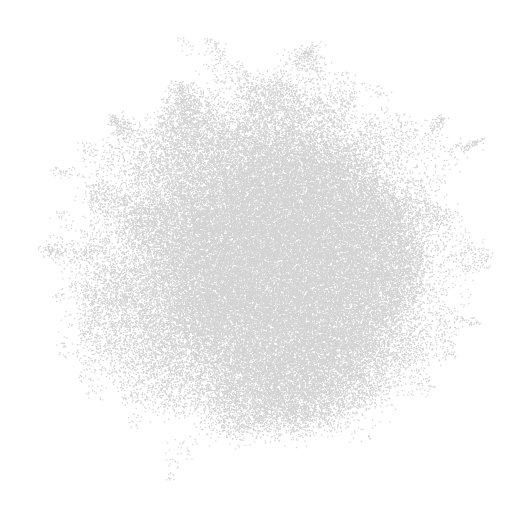

In [231]:
adata_inverted = sc.AnnData(X=X_inverted.cpu().numpy(), 
                           obs=obs)
sc.tl.pca(adata_inverted)
sc.pp.neighbors(adata_inverted)
sc.tl.umap(adata_inverted)
sc.pl.umap(adata_inverted)

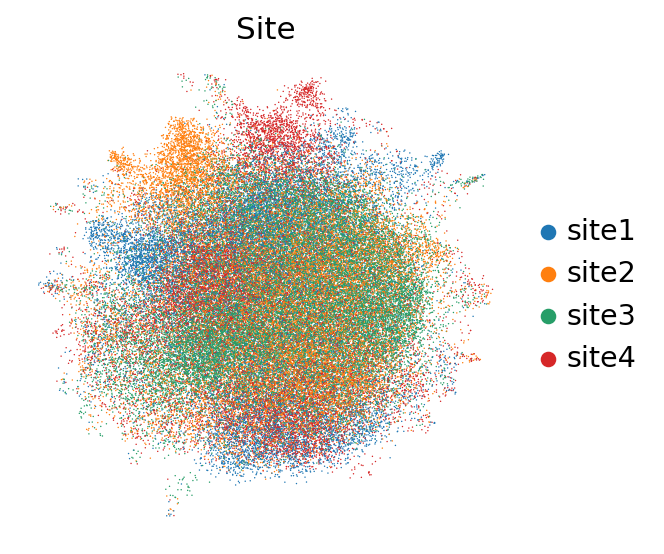

In [232]:
sc.pl.umap(adata_inverted, color="Site")

In [233]:
adata_corrected = sc.AnnData(X=X_corrected.cpu().numpy(), 
                           obs=obs)
sc.tl.pca(adata_corrected)
sc.pp.neighbors(adata_corrected)
sc.tl.umap(adata_corrected)

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


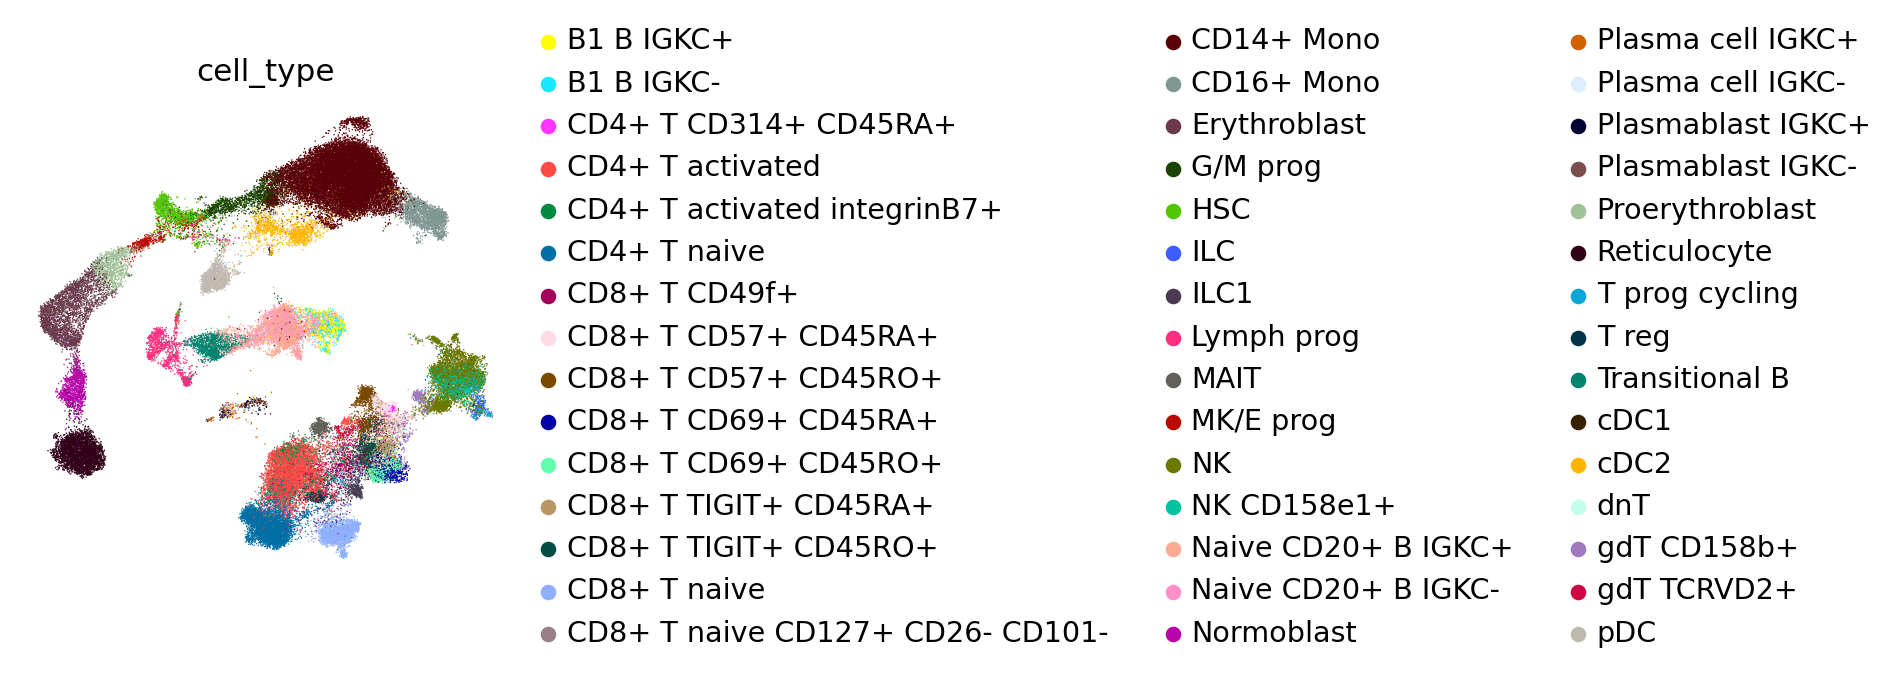

In [234]:
sc.pl.umap(adata_corrected, color="cell_type")

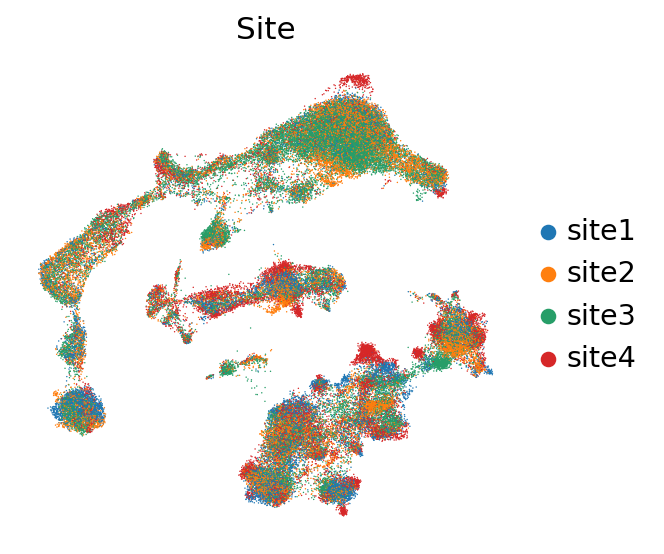

In [235]:
sc.pl.umap(adata_corrected, color="Site")

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


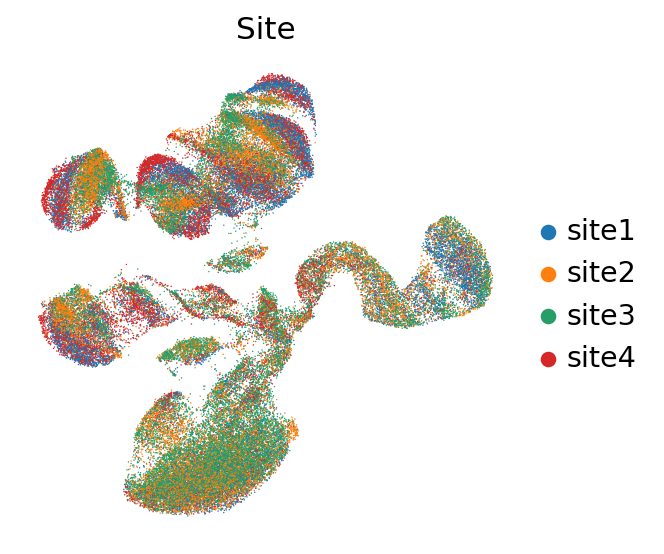

In [237]:
adata_corrected_decoded = sc.AnnData(X=X_corrected_decoded.cpu().numpy(), 
                           obs=obs)
adata_corrected_decoded.layers["X_counts"] = adata_corrected_decoded.X.copy()
sc.pp.normalize_total(adata_corrected_decoded, target_sum=1e4)
sc.pp.log1p(adata_corrected_decoded)
sc.tl.pca(adata_corrected_decoded)
sc.pp.neighbors(adata_corrected_decoded)
sc.tl.umap(adata_corrected_decoded)
sc.pl.umap(adata_corrected_decoded, color="Site")

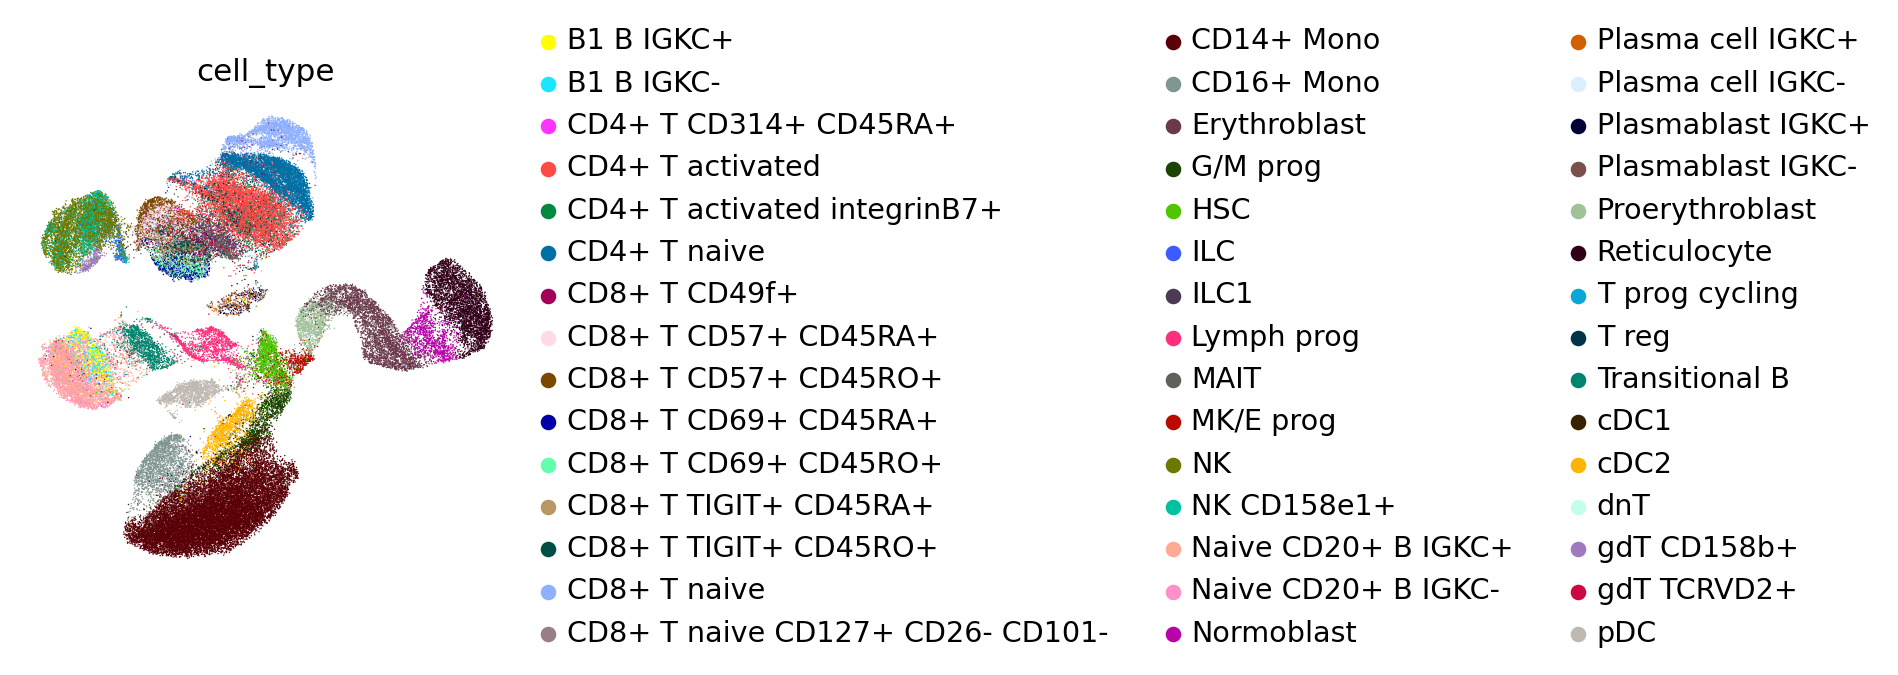

In [238]:
sc.pl.umap(adata_corrected_decoded, color="cell_type")